## 1) INTRODUÇÃO DO PROJETO

#### TEMA
**PREDIÇÃO DE DOENÇA DE SONO**

#### DESCRIÇÃO DO PROBLEMA

A qualidade do sono é essencial para a saúde física e mental, influenciando desempenho, regulação emocional e prevenção de doenças crônicas. Contudo, fatores como estresse, hábitos inadequados e condições médicas podem gerar distúrbios como insônia e apneia, afetando milhões de pessoas em todo o mundo e muitas vezes passando despercebidos no diagnóstico precoce.

**O objetivo dessa atividade** é combinar uma árvore de decisão e uma rede neural para identificar a presença de distúrbios do sono e validar a predição inicial, ajustando a probabilidade final do diagnóstico e aumentando a confiabilidade do sistema, além de obter dados do usuário, extração, e também permitir perguntas do usuário sobre o tema via chatbot 

#### DATASET UTILIZADO

Sleep Health and Lifestyle Dataset

**Origem (link do dataset)**: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset?resource=download

#### PARÂMETROS UTILIZADOS

**Inputs**
- **Gender**: Gênero do paciente (Male/Female)
- **Age**: Idade (anos)
- **Occupation**: Profissão
- **Sleep Duration**: Duração do sono (horas)
- **Physical Activity Level**: Nível de atividade física semanal (minutos)
- **Stress Level**: Nível de estresse (escala 1–10)
- **BMI Category**: Categoria de IMC (Normal, Overweight, Obese, etc.)
- **Blood Pressure**: Pressão arterial (mmHg)
- **Heart Rate**: Frequência cardíaca (bpm)
- **Daily Steps**: Passos diários
- **Quality of Sleep**: Score de qualidade do sono (1–10)

**Output**
- **Sleep Disorder**: Doença de sono (None, Sleep Apnea, Insomnia)

## 2) IMPORTS E CONFIGURAÇÕES

In [ ]:
import os
import warnings
from dotenv import load_dotenv
import mysql.connector
import random
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

## 3) CARREGAMENTO DAS VARIÁVEIS DE AMBIENTE

In [255]:
def load_env_variables():
    load_dotenv()
    
    return {
        "host": os.getenv("DB_HOST"),
        "user": os.getenv("DB_USER"),
        "password": os.getenv("DB_PASSWORD"),
        "database": os.getenv("DB_NAME")
    }

In [256]:
db_config = load_env_variables()

## 4) LEITURA DOS DADOS VIA MySQL

In [257]:
def fetch_sql_sleep_data():
    try:
        connection = mysql.connector.connect(
            host=db_config["host"],
            user=db_config["user"],
            password=db_config["password"],
            database=db_config["database"]
        )

        if connection.is_connected():
            cursor = connection.cursor(dictionary=True)

            sql_query = "SELECT * FROM sleep_data"
            cursor.execute(sql_query)

            data = cursor.fetchall()
            return pd.DataFrame(data);

    except mysql.connector.Error as error:
        print(f"Erro ao conectar ou consultar o banco: {error}")

    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()
            connection.close()
            print("Conexão encerrada.")

In [258]:
sleep_health_df = fetch_sql_sleep_data()

Conexão encerrada.


In [259]:
sleep_health_df.head(10)

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
0,1,Male,27,Other,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Other,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Other,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,6,Male,28,Other,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
7,8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,None
8,9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,None
9,10,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,None


## 5) EXPLORAÇÃO INICIAL DOS DADOS

In [260]:
sleep_health_df.isnull().sum()

person_id                  0
gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
blood_pressure             0
heart_rate                 0
daily_steps                0
sleep_disorder             0
dtype: int64

In [261]:
sleep_health_df.dtypes

person_id                    int64
gender                      object
age                          int64
occupation                  object
sleep_duration             float64
quality_of_sleep             int64
physical_activity_level      int64
stress_level                 int64
bmi_category                object
blood_pressure              object
heart_rate                   int64
daily_steps                  int64
sleep_disorder              object
dtype: object

In [262]:
print(sleep_health_df['gender'].value_counts().sort_index())
print()
print(sleep_health_df['occupation'].value_counts().sort_index())
print()
print(sleep_health_df['bmi_category'].value_counts().sort_index())
print()
print(sleep_health_df['sleep_disorder'].value_counts().sort_index())

gender
Female    4932
Male      5068
Name: count, dtype: int64

occupation
Accountant      977
Doctor         1891
Engineer       1659
Lawyer         1304
Nurse          1923
Other           278
Salesperson     891
Teacher        1077
Name: count, dtype: int64

bmi_category
Normal        5802
Obese          257
Overweight    3941
Name: count, dtype: int64

sleep_disorder
Insomnia       2088
None           5859
Sleep Apnea    2053
Name: count, dtype: int64


## 6) PRÉ-PROCESSAMENTO
- Conversão de pressão arterial
- Remoção de identificadores e coluna de pressão arterial

In [263]:
sleep_health_df[['systolic', 'diastolic']] = sleep_health_df['blood_pressure'].str.split('/', expand=True).astype(int)
sleep_health_df = sleep_health_df.drop(['person_id', 'blood_pressure'], axis=1)
sleep_health_df.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Male,27,Other,6.1,6,42,6,Overweight,77,4200,None,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Other,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Other,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


## 7) ENCODAMENTO DE VARIÁVEIS CATEGÓRICAS

In [264]:
# ÁRVORE DE DECISÃO

decision_tree_df = sleep_health_df.copy()

label_cols = decision_tree_df.select_dtypes(include='object').columns.to_list()

encoders_tree = {}

for col in label_cols:
    le = LabelEncoder()
    decision_tree_df[col] = le.fit_transform(decision_tree_df[col])
    encoders_tree[col] = le

decision_tree_df.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,1,27,5,6.1,6,42,6,2,77,4200,1,126,83
1,1,28,1,6.2,6,60,8,0,75,10000,1,125,80
2,1,28,1,6.2,6,60,8,0,75,10000,1,125,80
3,1,28,5,5.9,4,30,8,1,85,3000,2,140,90
4,1,28,5,5.9,4,30,8,1,85,3000,2,140,90


In [265]:
# REDE NEURAL

neural_network_df = sleep_health_df.copy()

target_col = "sleep_disorder"

x_nn = neural_network_df.drop(columns=[target_col])
y_nn = neural_network_df[target_col]

x_nn = pd.get_dummies(
    x_nn,
    drop_first = True
)

neural_network_df = pd.concat([x_nn, y_nn], axis=1)

## 8) ANÁLISE EXPLORATÓRIA E VISUALIZAÇÃO DOS DADOS 

In [266]:
decision_tree_df.describe()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.506800,42.144900,3.108800,7.126720,7.318000,59.581500,5.372300,0.813900,70.167600,6791.973200,0.996500,128.581500,84.597200
std,0.499979,8.721405,2.149145,0.844192,1.191729,20.855073,1.767316,0.969413,4.536757,1668.270346,0.643529,8.077195,6.409607
min,0.000000,25.000000,0.000000,5.300000,4.000000,30.000000,3.000000,0.000000,62.000000,2257.000000,0.000000,111.000000,72.000000
25%,0.000000,35.000000,1.000000,6.400000,6.000000,40.000000,4.000000,0.000000,67.000000,5504.750000,1.000000,123.000000,80.000000
50%,1.000000,42.000000,3.000000,7.100000,7.000000,58.000000,5.000000,0.000000,70.000000,6739.000000,1.000000,129.000000,83.000000
75%,1.000000,49.000000,4.000000,7.800000,8.000000,78.000000,7.000000,2.000000,73.000000,7910.000000,1.000000,134.000000,88.000000
max,1.000000,61.000000,7.000000,9.000000,9.000000,100.000000,8.000000,2.000000,89.000000,10800.000000,2.000000,146.000000,98.000000


/tmp/ipykernel_368/2341854402.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=decision_tree_df['sleep_disorder'], palette='viridis')


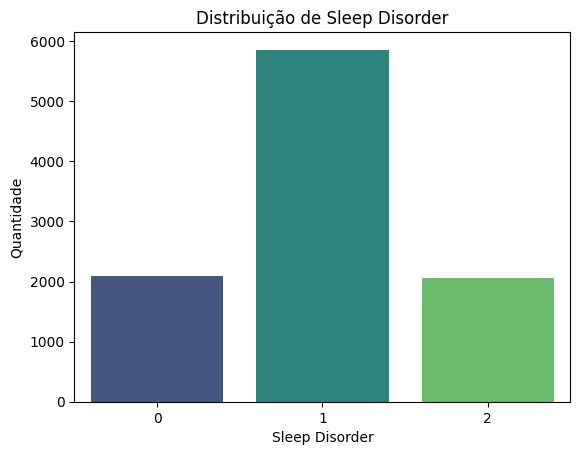

In [267]:
sns.countplot(x=decision_tree_df['sleep_disorder'], palette='viridis')
plt.title('Distribuição de Sleep Disorder')
plt.xlabel('Sleep Disorder')
plt.ylabel('Quantidade')
plt.show()

In [268]:
median_sleep_disease = decision_tree_df.groupby("sleep_disorder").median()
median_sleep_disease

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,systolic,diastolic
sleep_disorder,,,,,,,,,,,,
0,1.0,44.0,6.0,6.5,7.0,45.0,7.0,2.0,71.0,5956.0,132.0,87.0
1,1.0,38.0,2.0,7.4,8.0,60.0,5.0,0.0,69.0,7272.0,124.0,81.0
2,0.0,51.0,4.0,6.9,7.0,80.0,6.0,2.0,72.0,7385.0,139.0,94.0


array([[<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'occupation'}>],
       [<Axes: title={'center': 'sleep_duration'}>,
        <Axes: title={'center': 'quality_of_sleep'}>,
        <Axes: title={'center': 'physical_activity_level'}>],
       [<Axes: title={'center': 'stress_level'}>,
        <Axes: title={'center': 'bmi_category'}>,
        <Axes: title={'center': 'heart_rate'}>],
       [<Axes: title={'center': 'daily_steps'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'diastolic'}>]], dtype=object)

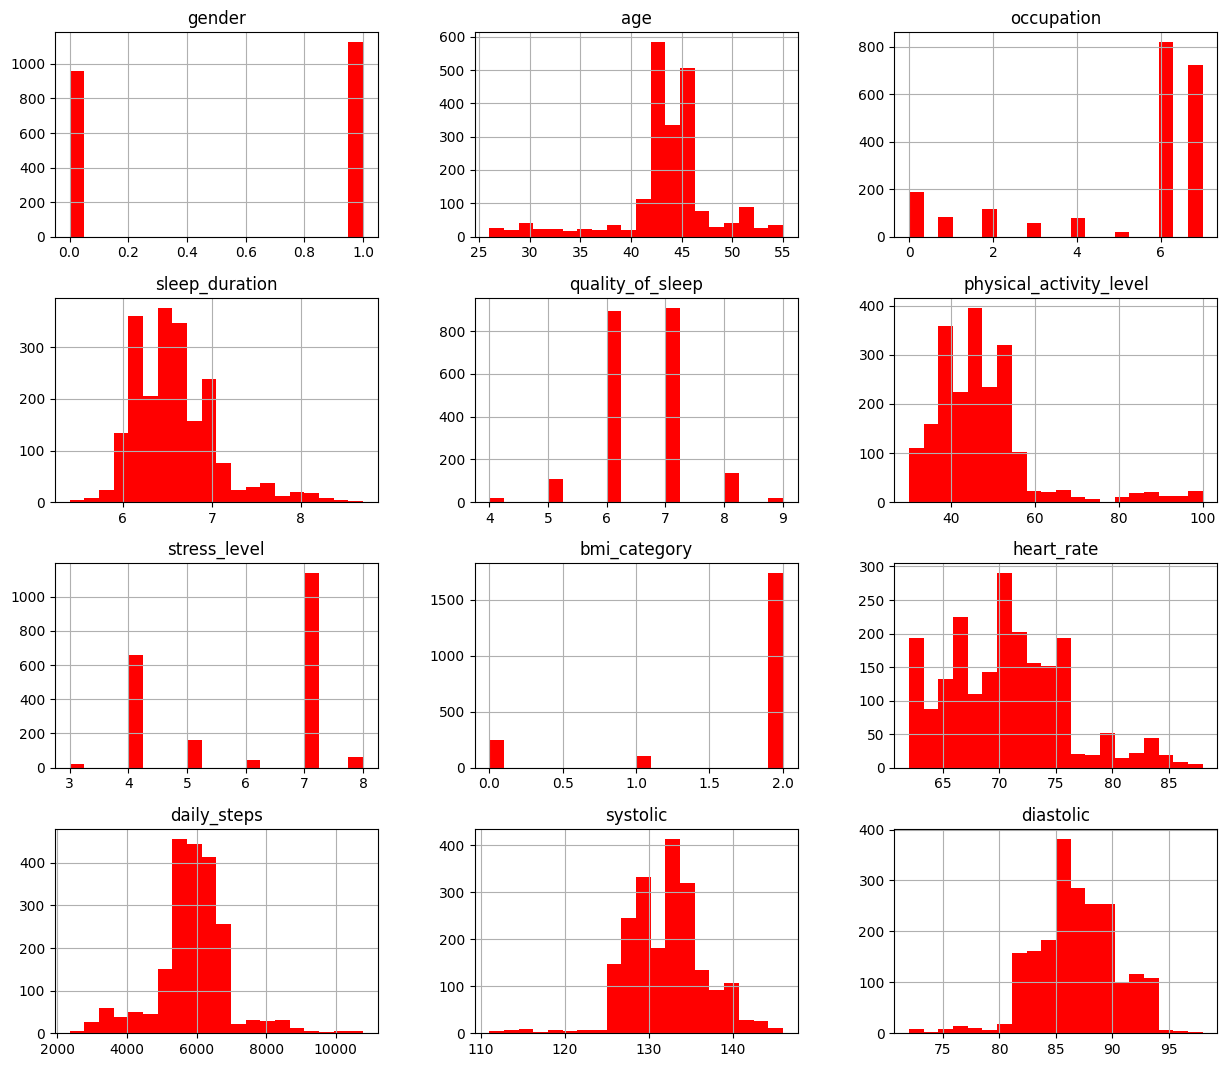

In [269]:
# QUEM TEM INSOMNIA (0)
insomnia_df = decision_tree_df[decision_tree_df['sleep_disorder'] == 0]
insomnia_df = insomnia_df.drop("sleep_disorder", axis = 1)

insomnia_df.hist(bins = 20, figsize = (15,13), color = 'red')

array([[<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'occupation'}>],
       [<Axes: title={'center': 'sleep_duration'}>,
        <Axes: title={'center': 'quality_of_sleep'}>,
        <Axes: title={'center': 'physical_activity_level'}>],
       [<Axes: title={'center': 'stress_level'}>,
        <Axes: title={'center': 'bmi_category'}>,
        <Axes: title={'center': 'heart_rate'}>],
       [<Axes: title={'center': 'daily_steps'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'diastolic'}>]], dtype=object)

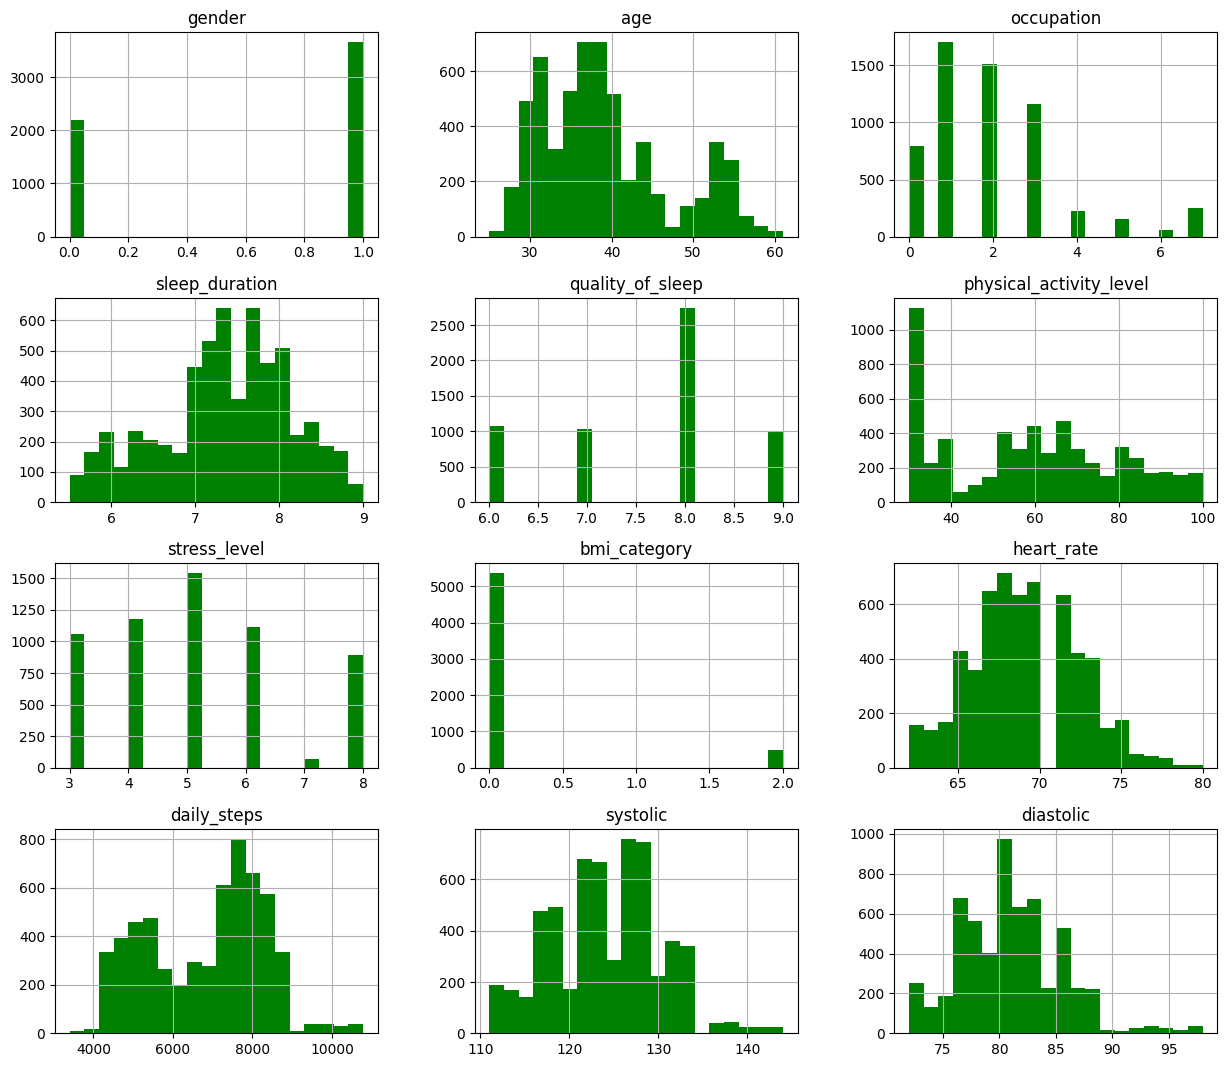

In [270]:
# PESSOAS SEM DOENÇA (1)
no_disorder_df = decision_tree_df[decision_tree_df['sleep_disorder'] == 1]
no_disorder_df = no_disorder_df.drop("sleep_disorder", axis = 1)

no_disorder_df.hist(bins = 20, figsize = (15,13), color = 'green')

array([[<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'occupation'}>],
       [<Axes: title={'center': 'sleep_duration'}>,
        <Axes: title={'center': 'quality_of_sleep'}>,
        <Axes: title={'center': 'physical_activity_level'}>],
       [<Axes: title={'center': 'stress_level'}>,
        <Axes: title={'center': 'bmi_category'}>,
        <Axes: title={'center': 'heart_rate'}>],
       [<Axes: title={'center': 'daily_steps'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'diastolic'}>]], dtype=object)

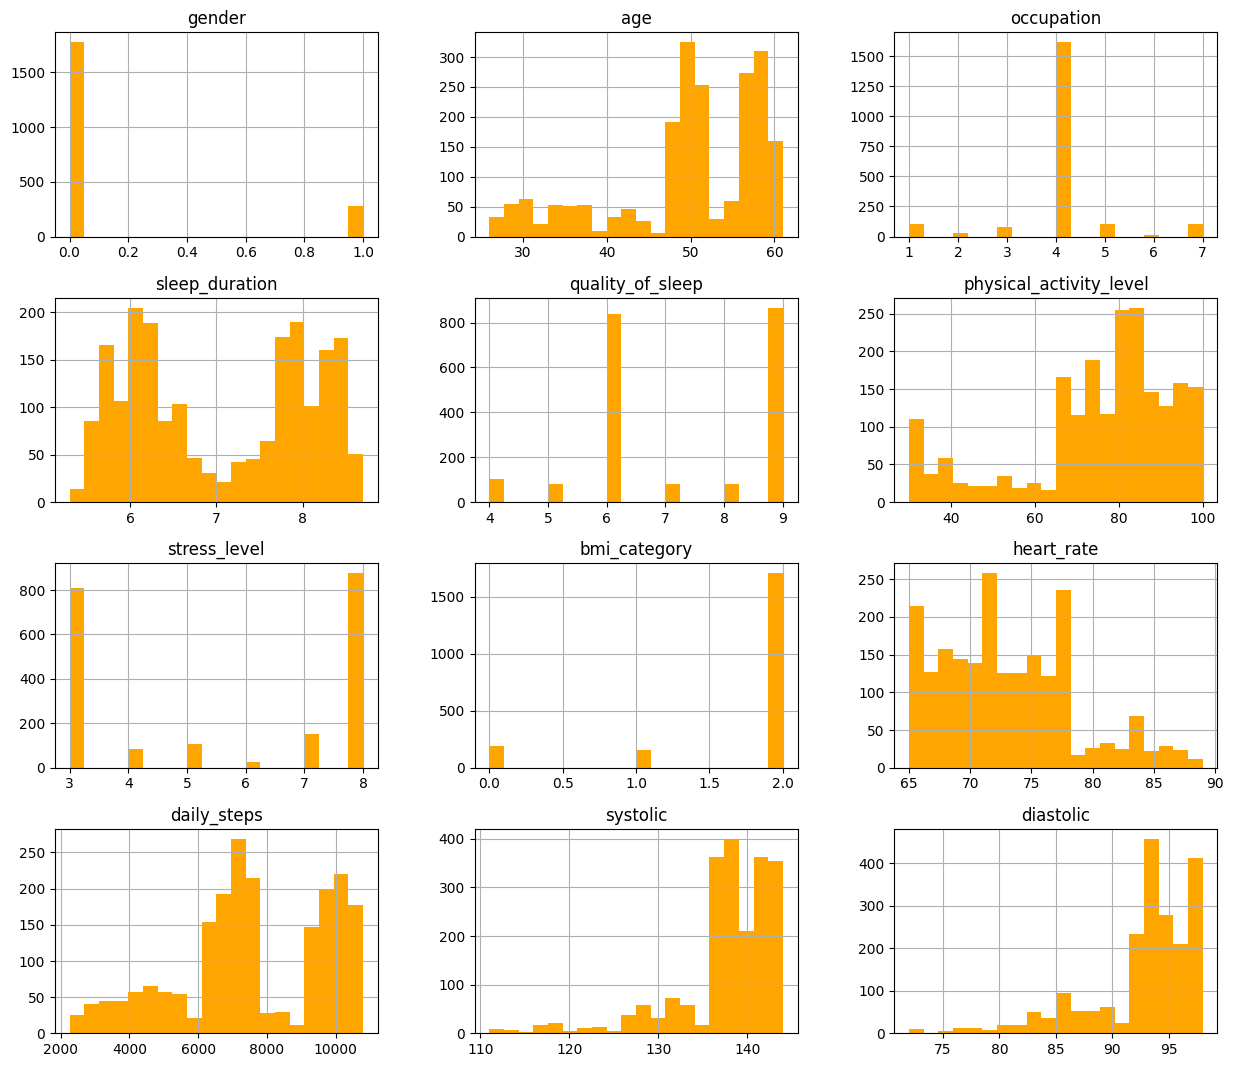

In [271]:
# QUEM TEM APNÉIA DE SONO (2)
apnea_df = decision_tree_df[decision_tree_df['sleep_disorder'] == 2]
apnea_df = apnea_df.drop("sleep_disorder", axis = 1)

apnea_df.hist(bins = 20, figsize = (15,13), color = 'orange')

In [272]:
correlation = decision_tree_df.corr(method='pearson') # type: ignore
correlation

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
gender,1.000000,-0.578484,-0.156959,-0.117553,-0.292495,0.008296,0.406231,-0.336302,0.197729,-0.001789,-0.259003,-0.193239,-0.247058
age,-0.578484,1.000000,0.272555,0.321451,0.468801,0.173208,-0.419950,0.523299,-0.199429,0.054435,0.230903,0.570934,0.561175
occupation,-0.156959,0.272555,1.000000,-0.279408,-0.261153,-0.088934,0.027066,0.696547,0.036092,-0.083590,-0.186289,0.525607,0.519183
sleep_duration,-0.117553,0.321451,-0.279408,1.000000,0.828248,0.210614,-0.758282,-0.347784,-0.433671,-0.026466,0.184411,-0.152138,-0.138847
quality_of_sleep,-0.292495,0.468801,-0.261153,0.828248,1.000000,0.197793,-0.897785,-0.299543,-0.596202,0.030231,0.195887,-0.108741,-0.098198
physical_activity_level,0.008296,0.173208,-0.088934,0.210614,0.197793,1.000000,-0.037532,0.058516,0.109668,0.721932,0.429683,0.239402,0.348659
stress_level,0.406231,-0.419950,0.027066,-0.758282,-0.897785,-0.037532,1.000000,0.156142,0.609062,0.164388,-0.048537,0.089964,0.080073
bmi_category,-0.336302,0.523299,0.696547,-0.347784,-0.299543,0.058516,0.156142,1.000000,0.217574,0.009520,0.002483,0.681285,0.717333
heart_rate,0.197729,-0.199429,0.036092,-0.433671,-0.596202,0.109668,0.609062,0.217574,1.000000,-0.031485,0.170725,0.245098,0.219151
daily_steps,-0.001789,0.054435,-0.083590,-0.026466,0.030231,0.721932,0.164388,0.009520,-0.031485,1.000000,0.326204,0.092507,0.222193


<Axes: >

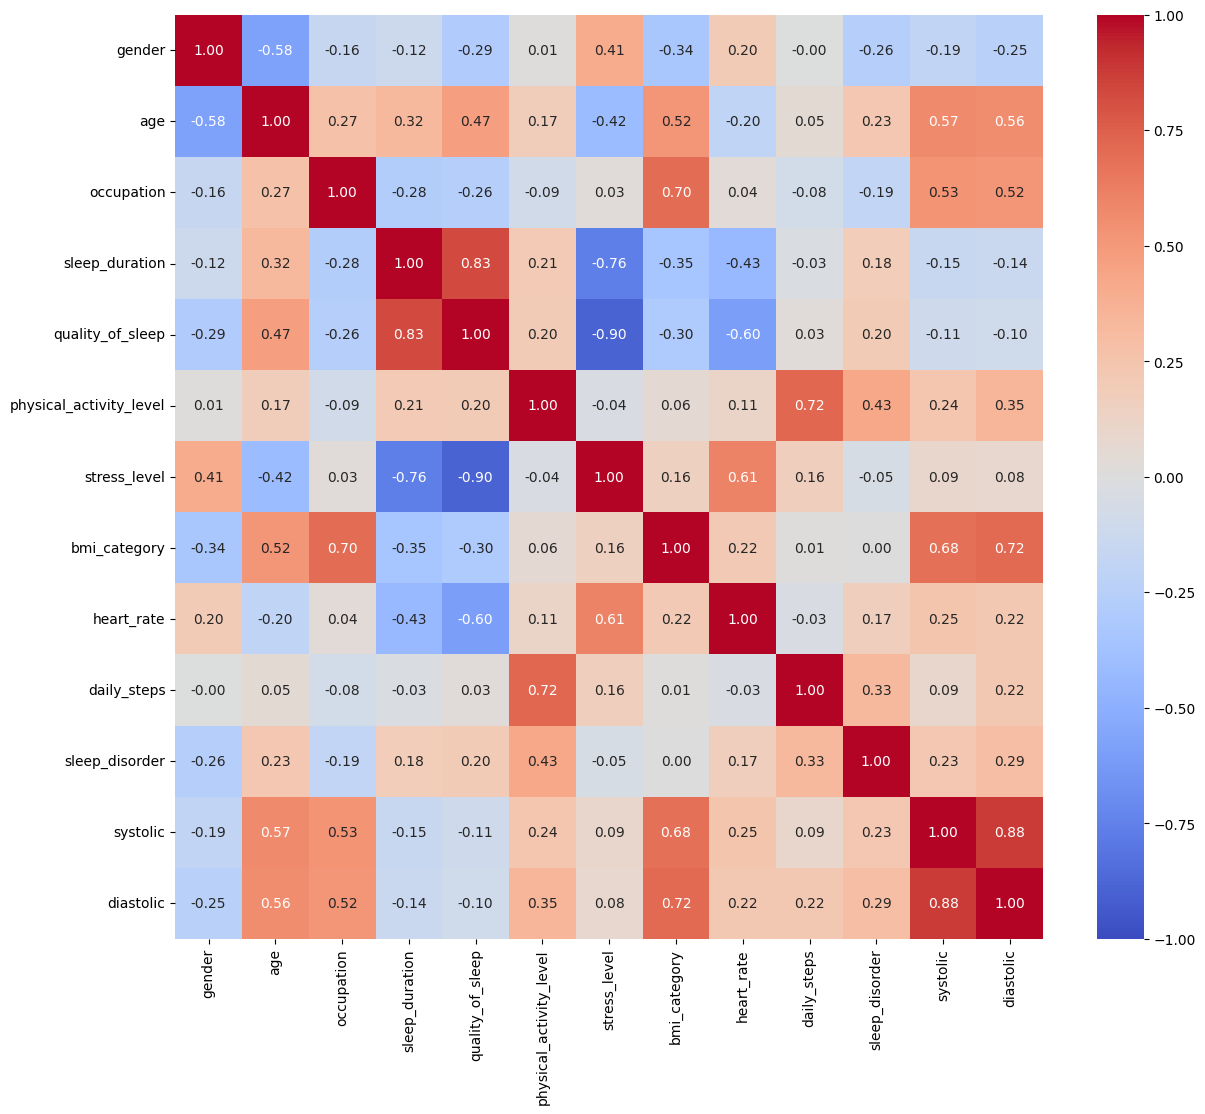

In [273]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, cmap = 'coolwarm', vmin = -1.0, vmax = 1.0, fmt = '.2f', annot = True)

## 9) PREPARAÇÃO DOS DADOS PARA TREINAMENTO DOS MODELOS


In [274]:
def prepare_data(
    df,
    target_col,
    model_type="tree",
    test_size=0.3,
    random_state=42
):
    df = df.copy()

    X = df.drop(columns=[target_col])
    y = df[target_col]

    target_encoder = None

    if model_type == "nn":
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(y)

    x_train, x_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    scaler = None

    if model_type == "nn":
        scaler = MinMaxScaler()

        x_train = scaler.fit_transform(x_train)  
        x_test = scaler.transform(x_test)     

    smote = SMOTE(random_state=random_state)
    x_train_bal, y_train_bal = smote.fit_resample(x_train, y_train)

    return {
        "x_train": x_train,
        "x_test": x_test,
        "y_train": y_train,
        "y_test": y_test,
        "x_train_bal": x_train_bal,
        "y_train_bal": y_train_bal,
        "scaler": scaler         
    }

In [275]:
tree_data = prepare_data(
    df=decision_tree_df,
    target_col="sleep_disorder",
    model_type="tree"
)

x_train_tree = tree_data["x_train"]
y_train_tree = tree_data["y_train"]

x_train_bal_tree = tree_data["x_train_bal"]
y_train_bal_tree = tree_data["y_train_bal"]

In [276]:
nn_data = prepare_data(
    df=neural_network_df,
    target_col="sleep_disorder",
    model_type="nn"
)

x_train_nn = nn_data["x_train"]
y_train_nn = nn_data["y_train"]

x_train_bal_nn = nn_data["x_train_bal"]
y_train_bal_nn = nn_data["y_train_bal"]

scaler_nn = nn_data["scaler"]

## 10) TREINANDO MODELOS DE CLASSIFICAÇÃO

In [277]:
def train_decision_tree(
    X_train_balanced,
    y_train_balanced,
    X_test,
    y_test
):
    model = DecisionTreeClassifier(
        max_depth=5,
        criterion="entropy",
        class_weight="balanced"
    )

    model.fit(X_train_balanced, y_train_balanced)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=model.classes_
    )

    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - Decision Tree")
    plt.show()

    return model

In [278]:
def train_neural_network(
    X_train,
    y_train,
    X_test,
    y_test
):
    model = MLPClassifier(
        solver="adam",
        activation="relu",
        alpha=1e-8,
        hidden_layer_sizes=(490, 490),
        random_state=1,
        max_iter=1000,
        early_stopping=True
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=model.classes_
    )

    disp.plot(cmap="Greens", values_format="d")
    plt.title("Confusion Matrix - Neural Network")
    plt.show()

    return model

Accuracy: 0.9183333333333333

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       626
           1       0.95      0.95      0.95      1758
           2       0.87      0.90      0.88       616

    accuracy                           0.92      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.92      0.92      0.92      3000



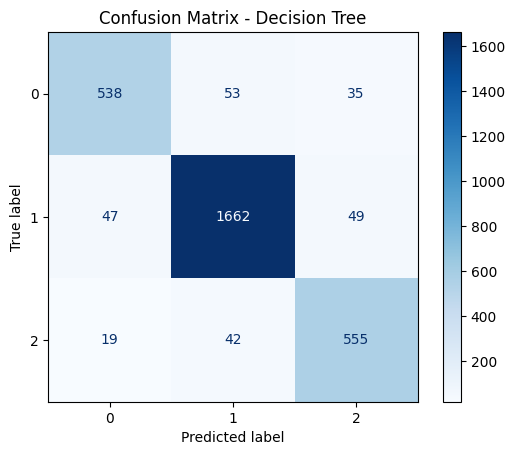

In [279]:
tree_model = train_decision_tree(
    X_train_balanced=tree_data["x_train_bal"],
    y_train_balanced=tree_data["y_train_bal"],
    X_test=tree_data["x_test"],
    y_test=tree_data["y_test"]
)

Accuracy: 0.9286666666666666

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       626
           1       0.95      0.96      0.95      1758
           2       0.90      0.89      0.90       616

    accuracy                           0.93      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.93      0.93      0.93      3000



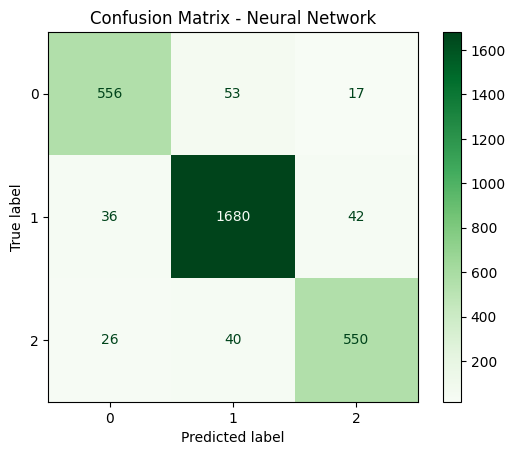

In [281]:
nn_model = train_neural_network(
    X_train=nn_data["x_train_bal"],
    y_train=nn_data["y_train_bal"],
    X_test=nn_data["x_test"],
    y_test=nn_data["y_test"]
)